In [6]:
import numpy as np
import pandas as pd
from io import StringIO

import tensorflow as tf
import unifier

from tensorflow.keras import datasets,layers, models
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [7]:
def encode(value):
    if value == '22-25':
        return [0]
    elif value == '26-30':
        return [1]
    elif value == '31-35':
        return [2]
    else:
        raise NameError(value)

def stripArr(stri):
    str2 = stri.replace('\n', '')
    return str2[1:len(str2)-1]

def convertString(arr):
    return np.genfromtxt(StringIO(stripArr(arr)),dtype=np.float).reshape(DATA_SHAPE)

DATA_SHAPE = (6,6,24)
df = pd.read_csv("processed.csv")
df['dataBinned'] = df['dataBinned'].map(lambda x:convertString(x))


In [8]:
def createNetwork():
    return models.Sequential([
        layers.Conv2D(32, (1, 1), activation='relu', input_shape=DATA_SHAPE),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax'),
    ])


In [9]:
model = createNetwork()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 32)          800       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 72,867
Trainable params: 72,867
Non-trainable params: 0
____________________________________________________

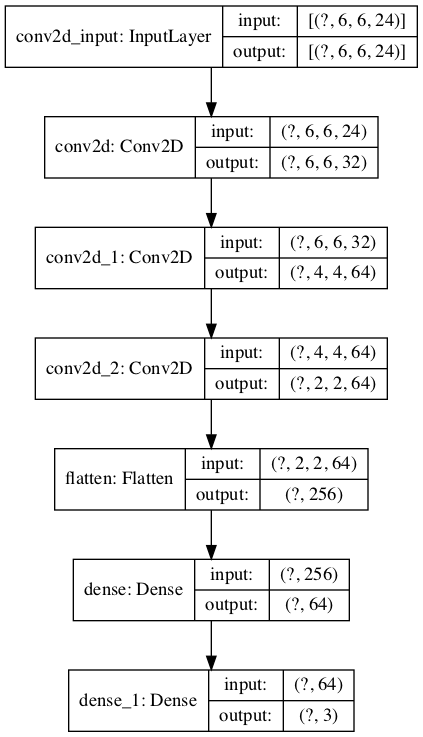

In [10]:
plot_model(model,show_shapes=True)

In [11]:
X = np.stack(df['dataBinned'].values)
y = np.stack(df['age'].map(lambda x : encode(x)).values)

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [12]:
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test))

Train on 1878 samples, validate on 627 samples
Epoch 1/30
1878/1878 [==============================] - 3s 2ms/sample - loss: 0.7636 - accuracy: 0.6624 - val_loss: 0.5269 - val_accuracy: 0.7719
Epoch 2/30
1878/1878 [==============================] - 1s 472us/sample - loss: 0.4844 - accuracy: 0.8126 - val_loss: 0.4603 - val_accuracy: 0.8150
Epoch 3/30
1878/1878 [==============================] - 1s 463us/sample - loss: 0.3850 - accuracy: 0.8578 - val_loss: 0.3472 - val_accuracy: 0.8533
Epoch 4/30
1878/1878 [==============================] - 1s 529us/sample - loss: 0.2644 - accuracy: 0.8978 - val_loss: 0.3240 - val_accuracy: 0.8852
Epoch 5/30
1878/1878 [==============================] - 1s 524us/sample - loss: 0.2489 - accuracy: 0.9159 - val_loss: 0.2855 - val_accuracy: 0.8915
Epoch 6/30
1878/1878 [==============================] - 1s 441us/sample - loss: 0.1937 - accuracy: 0.9292 - val_loss: 0.2688 - val_accuracy: 0.8884
Epoch 7/30
1878/1878 [==============================] - 1s 611us/sa

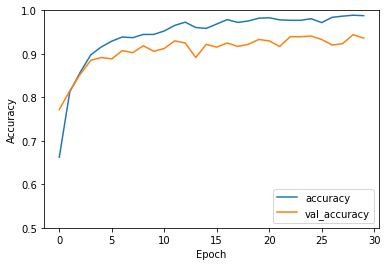


Validation accuracy of: 0.936


In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
print("\nValidation accuracy of: {0:.3f}".format(history.history['val_accuracy'][29]))

In [14]:
model.save('CNN.h5')

In [15]:
df = pd.read_csv("processed-eval.csv")
df['dataBinned'] = df['dataBinned'].map(lambda x:convertString(x))

In [25]:
X = np.stack(df['dataBinned'].values)

In [51]:
def decode(value):
    if value == 0:
        return '22-25'
    elif value == 1:
        return '26-30'
    elif value == 2:
        return '31-35'
    else:
        raise NameError(value)

In [27]:
y = model.predict(X)


In [52]:
df['age'] = [decode(np.argmax(e)) for e in y]

In [55]:
df[['id', 'age', 'gender']].to_csv("predictions.csv")